In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

Given data from ocean waves, we can utilize advanced signal processing to analyze and refine the information. Ocean wave data, which is typically recorded as time-series signals representing wave heights, can be noisy and influenced by various external factors. To extract meaningful insights, we can utilize methods such as the Discrete Fourier Transform (DFT) to transition the data from the time domain to the frequency domain, enabling us to identify the dominant wave frequencies and amplitudes.

### Analytical Process:

The wave height data represents the time-series signal $h(t)$, where $t$ is the time in seconds. This can be represented by a sum of various frequency components, with each representing a sin wave with a specific frequency and amplitude.

$h(t)=\sum_{i=1}^{N} A_i cos(2\pi f_i t+\phi_i)$ + Noise$(t)$

$A_i$: amplitude of wave

$f_i$: frequency of wave

$\phi_i$: wave phase

Noise$(t)$: random noise added to account for measurement errors

The Discrete Fourier Transformation (DFT) [[3]](#References) is used to transform the time-domain signal into its frequency-domain representation by decomposing the signal into a sum of sin and cos waves. This allows a manipulation the signal's frequency components. This also requires
assumptions of periodicity, discrete samples, finite furation, and equally spaced samples.

$X[k]=\frac{1}{N} \sum_{n=0}^{N-1} x[n]e^{\frac{-j2 \pi kn}{N}}$

$X[k]$: complex Fourier coefficient at frequency bin, $k$

$x[n]$: signal amplitude at sample, $n$

$N$: number of samples

$k$: index of the frequency bin
   
where the index is related to the frequency by:

$f_k=\frac{k}{T}=k(\frac{Sampling Rate}{N})$

The power spectrum provides the energy contribution of each frequency to the signal and can be calculated using:

$P[k]=|X[k]|^2$

$P[k]$: power frequency at $f_k$

$|X[k]|$: magnitude of the complex Fourier coefficient

We can then filter noise by removing high-frequency components. We can define a cutoff frequency to eliminate high-frequency noise.

$f_c$: cutoff frequency 

$X[k]\begin{cases}
    X[k] & \text{if $f_x \leq f_c$}\\
    0 & \text{if $f_x > f_c$}
  \end{cases}$

After filtering the signal, the inverse FFT is applied to transform the modified frequency spectrum back into the time domain. The IFFT reconstructs the signal by summing the sine and cosine waves corresponding to the filtered frequency components and results in a cleaner version of the original signal.

$x[n]=\frac{1}{N} \sum_{k=0}^{N-1} X[k]e^{\frac{j2 \pi mn}{N}}$ [[2]](#References)

### Assumptions:
1. The wave height exhibits both short-term variability and long-term trends, where short-term fluctuations are removed in favor of longer-term trends

2. Null values and data exclusions do not introduce bias

3. The signal is dominated by frequencies below the Nyquist limit

4. The signal is assumed to be stationary over the period of analysis

5. The wave height data is sampled at uniform intervals in time

6. The noise added to the wave height data is assumed to be random and independent of the wave signal

7. The inverse Fourier Transform assumes no discontinuities at the boundaries of the signal

### Example Code with Chosen Parameters:

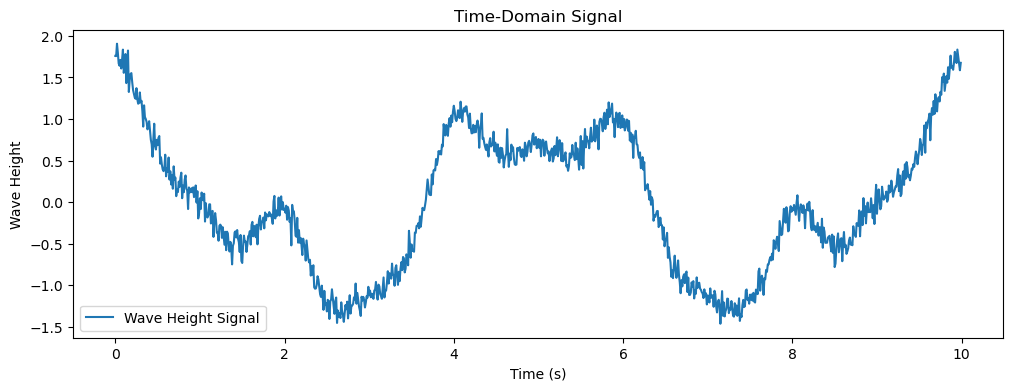

In [2]:
#sampling parameters
sampling_rate = 100 #Hz
duration = 10 #seconds
N = sampling_rate * duration #total number of samples
t = np.linspace(0, duration, N, endpoint=False) #time array

#signal parameters
frequencies = [0.2, 0.5, 1.0] #frequencies in Hz
amplitudes = [1.0, 0.5, 0.2] #amplitudes of the waves
noise_amplitude = 0.1 #noise level

#generating wave height signal
signal = sum(a * np.cos(2 * np.pi * f * t) for a, f in zip(amplitudes, frequencies))
signal += noise_amplitude * np.random.normal(size=len(t)) #add random noise

#plot the time domain signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal, label="Wave Height Signal")
plt.title("Time-Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Wave Height")
plt.legend()
plt.show()

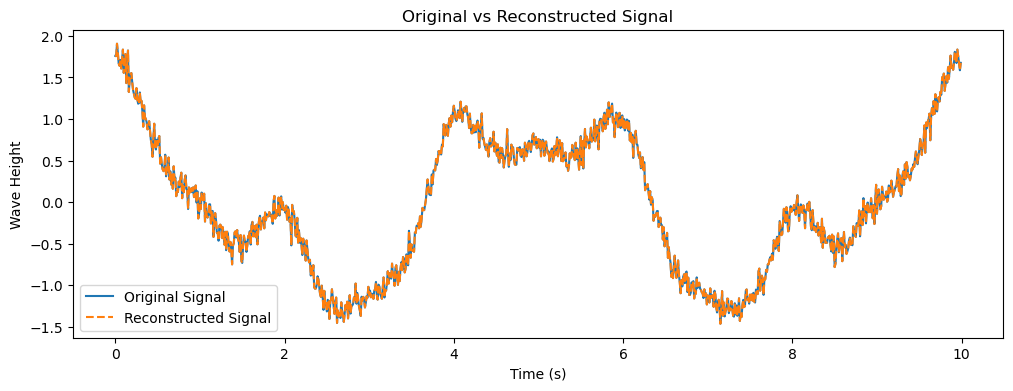

In [3]:
fft_result = np.fft.fft(signal) #compute the FFT
frequencies = np.fft.fftfreq(N, d=1/sampling_rate) #frequency bins

#only keep the positive frequencies
positive_frequencies = frequencies[:N//2]
power_spectrum = np.abs(fft_result[:N//2])**2 #compute the power spectrum

#reconstruct the Signal
reconstructed_signal = np.fft.ifft(fft_result).real #apply inverse FFT

#plot the original and reconstructed signals
plt.figure(figsize=(12, 4))
plt.plot(t, signal, label="Original Signal")
plt.plot(t, reconstructed_signal, '--', label="Reconstructed Signal")
plt.title("Original vs Reconstructed Signal")
plt.xlabel("Time (s)")
plt.ylabel("Wave Height")
plt.legend()
plt.show()

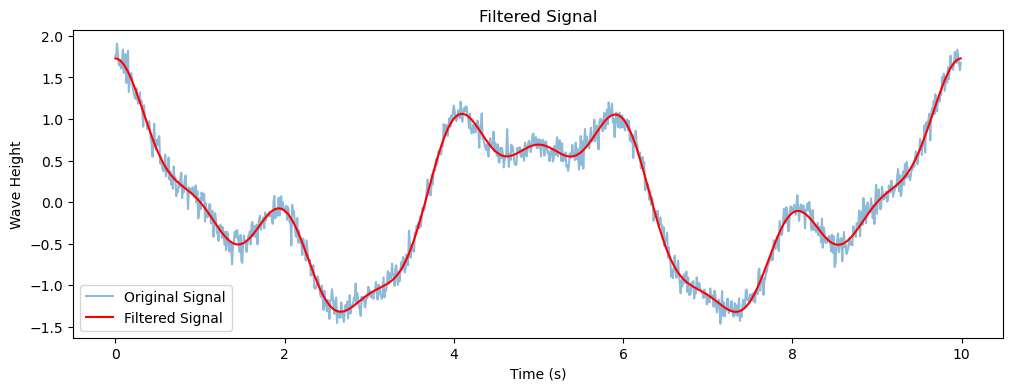

In [4]:
#noise filtering
cutoff_frequency = 1.0 #Hz
filtered_fft = fft_result.copy()
filtered_fft[np.abs(frequencies) > cutoff_frequency] = 0 #zero out high frequencies

#reconstruct the filtered signal
filtered_signal = np.fft.ifft(filtered_fft).real

#plot filtered signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal, label="Original Signal", alpha=0.5)
plt.plot(t, filtered_signal, label="Filtered Signal", color='red')
plt.title("Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Wave Height")
plt.legend()
plt.show()

### Utilizing Real Data:

The script below performs the following:
1. Loads and preprocess wave height data ('Hs') from a coastal data system CSV file
2. Performs Fast Fourier Transform (FFT) to analyze the frequency components of the signal
3. Applies a frequency filter to remove high-frequency noise
5. Reconstructs the filtered signal using inverse FFT
6. Visualizes the original and filtered signals

Objectives:
1. Identify significant frequency components in the wave height data
2. Improve signal quality through filtering

Dataset:
- The dataset contains time-series wave height measurements recorded at regular
30-minute intervals


The utilized data set [[1]](#References) contains wave data collected by oceanographic wave measuring buoys anchored at Mooloolaba, Queensland.

Nyquist Frequency: 0.0002777777777777778 Hz
Frequency Range: 0.0 to 0.00027776187204153307 Hz
Frequency Resolution: 1.5877552316534883e-08 Hz


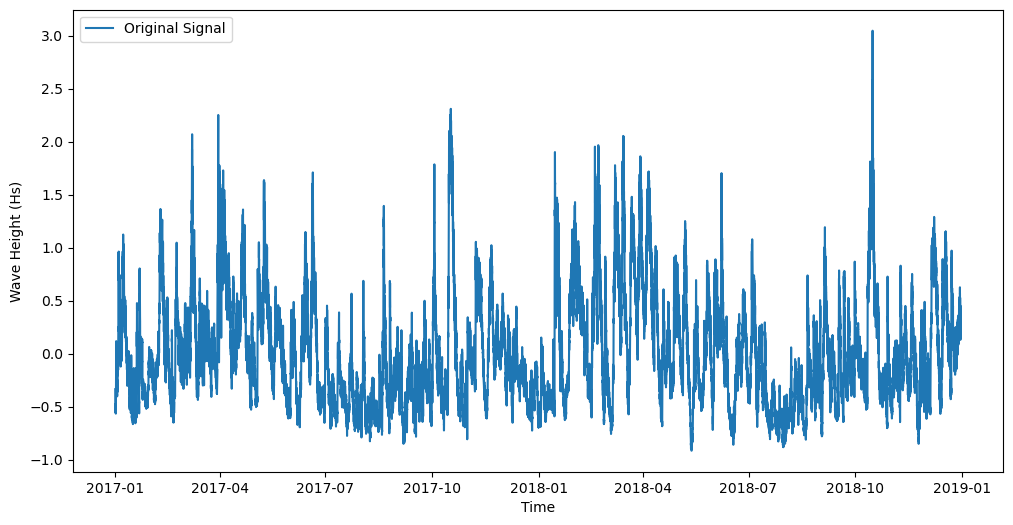

In [5]:
#load and inspect data
file_path = '/Users/annafrancisco/Downloads/CoastalDataSystem.csv'
data = pd.read_csv(file_path)

#convert 'Date/Time' column to datetime objects
data['Date/Time'] = pd.to_datetime(data['Date/Time'], infer_datetime_format=True)

#replace invalid or missing values with NaN and drop
data.replace(-99.9, np.nan, inplace=True)
data.dropna(subset=['Hs'], inplace=True)

#filter data
data = data[data['Date/Time'] < '2018-12-31']

#extract Hs and time
signal = data['Hs'].values
time = data['Date/Time']

#preprocess the Signal
signal = signal - np.mean(signal)  #removes the DC offset

#FFT
sampling_interval = 30 * 60
sampling_rate = 1 / sampling_interval  #sampling rate in Hz

#total duration of the signal in seconds
total_duration = (time.iloc[-1] - time.iloc[0]).total_seconds()

#FFT on the signal
fft_result = np.fft.fft(signal)

#frequency bins (positive and negative)
frequencies = np.fft.fftfreq(len(signal), d=sampling_interval)

#only keep the positive frequencies
positive_frequencies = frequencies[:len(frequencies)//2]
positive_fft_result = fft_result[:len(fft_result)//2]

#calculate the nyquist frequency
nyquist_frequency = 0.5 * sampling_rate  #nyquist frequency
print(f"Nyquist Frequency: {nyquist_frequency} Hz")
print(f"Frequency Range: {positive_frequencies[0]} to {positive_frequencies[-1]} Hz")
print(f"Frequency Resolution: {1/total_duration} Hz")

#apply frequency filtering
cutoff_frequency = 0.000001
filtered_fft = positive_fft_result.copy()

#zero out frequencies above the cutoff
filtered_fft[np.abs(positive_frequencies) > cutoff_frequency] = 0

#reconstruct filtered signal
filtered_signal = np.fft.ifft(np.concatenate([filtered_fft, np.zeros_like(filtered_fft)])).real 
filtered_signal = np.maximum(filtered_signal, -1) #clipping below -1

plt.figure(figsize=(12, 6))
plt.plot(time, signal, label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Wave Height (Hs)')
plt.legend()

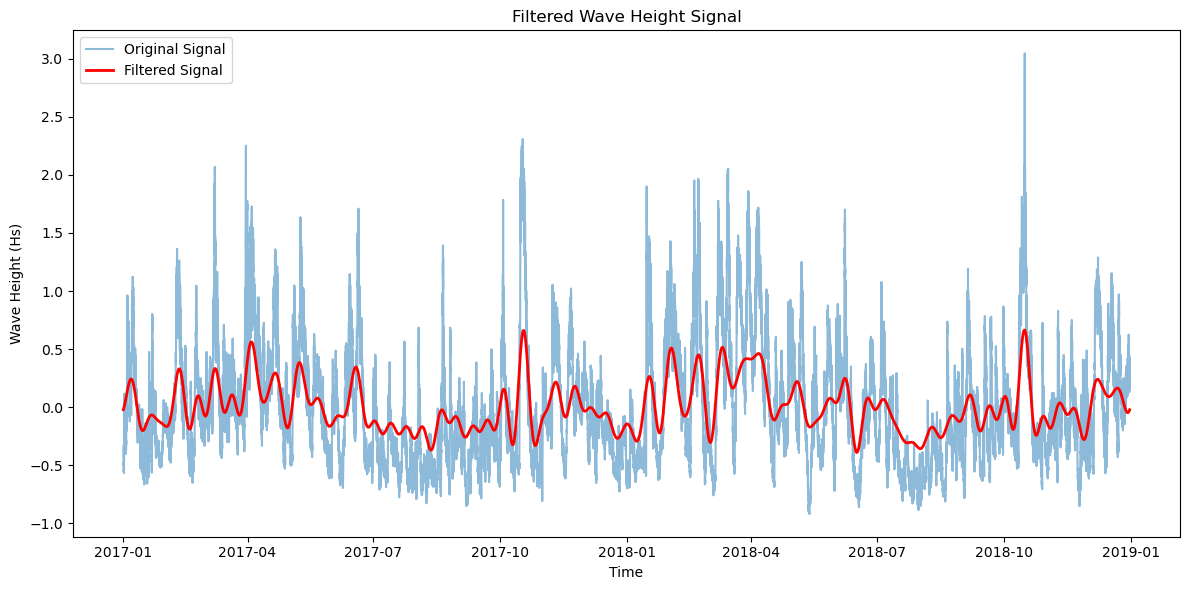

In [6]:
#plot filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal, label='Original Signal', alpha=0.5)
plt.plot(time, filtered_signal, label='Filtered Signal', color='red', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Wave Height (Hs)')
plt.title('Filtered Wave Height Signal')
plt.legend()
plt.tight_layout()
plt.show()

### Results Analysis:

The original signal exhibits significant variability and high-frequency oscillations. Spikes in the original signal indicate short-duration, high-intensity wave events. Where the filtered signal shows a smoothed version of the original data which captures the underlying trend of the wave height while reducing noise and high-frequency variations. The filter applied appears to be effective in preserving the main structure of the data while removing short-term fluctuations.

The filtered signal reflects a consistent pattern of periodicity and amplitude variation over the observed period, which can indicate recurring wave height dynamics and trends. Seasonal or event-based trends may be present, as suggested by the clusters of higher activity at specific intervals.

The filtered signal generally stays within a narrower range compared to the original signal, as the extreme peaks of the wave heights are significantly smoothed out. The applied filtering technique is useful for analyzing long-term trends and periodic behaviors in wave height while ignoring short-term noise or anomalies.

### Evaluation of Model:

The usage of low-pass filtering to remove high-frequency noise is a common and reasonable approach in several signal processing applications. By focusing on longer-term trends in wave heights and removing short-term noise, the model should correctly approximate the underlying physical behavior of ocean waves, where high-frequency noise often corresponds to measurement errors or environmental disturbances.

The model utilizes IFFT to reconstruct the filtered wave height signal after applying the low-pass filter in the frequency domain. As inverse FFT is a direct method for transforming data back to the time domain, this step is essential for understanding the impact of filtering on the original signal. It ensures that the process remains reversible, so the reconstructed signal is an accurate representation of the filtered version of the original data.

Given the low Nyquist frequency, the cutoff eliminates minute fluctuations that are not as relevant for long-term wave height trends. The goal of removing high-frequency components is inline with emphasizing longer-term changes in ocean wave heights. This is a reasonable approach when the objective is to focus on broader trends, while ignoring short-term fluctuations.

### Potential Issues with the Current Model Based on Assumptions and Real-Life Wave Height Data

1. *Excessively Coarse Filtering:*

    The low-pass filter applied in the current model is too coarse to effectively capture the relevant wave height information while eliminating noise. A more finely tuned filter would be necessary to retain the useful high-frequency components of the signal while filtering out noise. As the Nyquist frequency and frequency range of the data are extremely small (~0.00028 Hz), the filter may remove critical details that contribute to wave height variations over short timescales. In real-world data, wave heights exhibit a mix of slow and faster fluctuations. A coarse filter may unintentionally smooth out the significant short-term variations. More sophisticated, adaptive filters or varying cutoff frequencies based on signal characteristics could address this issue.


2. *Nyquist Frequency and Frequency Range:*

    The Nyquist frequency in this model is extremely low, which suggests the sampling rate and frequency range are very limited. This could imply that the resolution of the frequency analysis is insufficient to capture more rapid wave fluctuations that are important in real-world scenarios. The frequency resolution of the current model (~1.6e-08 Hz) may be too small for practical use, creating potential inaccuracies in the power spectrum.


3. *Noise Characteristics:*

    The assumption that the noise is simply random and independent of the wave signal may not hold in all cases. Ocean wave data is often subject to non-Gaussian noise, such as bias from sensors or environmental interference. If the noise has spectral characteristics that overlap with the signal, filtering out these frequencies may unintentionally remove signal components. The model assumes Gaussian noise, which is common in controlled conditions, but in real-life data, non-Gaussian noise could be present, especially when sensors are affected by environmental conditions.


4. *Frequency Spectrum Assumptions:*

    The current model assumes a simple frequency spectrum based on the Fourier Transform. However, real-world ocean wave data may involve more complex spectral patterns which may not be well represented by a basic Fourier analysis.If the signal consists of a mixture of periodic and non-periodic components, a pure frequency-domain approach might not capture all of the relevant information about the wave's physical characteristics.


5. *Signal Stationarity:*

    The model assumes that the wave signal is stationary, meaning its statistical properties remain constant over time. However, real ocean wave data can be non-stationary, especially over long periods. Wave patterns may evolve due to seasonal changes or weather events. This assumption of stationarity may cause issues when analyzing data from more variable environments.


6. *Boundary and Environmental Conditions:*

    The model assumes that boundary effects (such as waves interacting with the shore) are negligible, but in real-world coastal or near-shore environments, these effects can significantly influence the wave heights, especially during high-energy events like storms or tsunamis. The model also neglects environmental factors that may influence wave heights, such as water temperature. 


7. *Assumption of No Wave Breakage:*

    The assumption that wave heights are representative of non-breaking waves may not hold for real-world ocean wave data, particularly in coastal regions where breaking waves are common. Wave breaking introduces non-linear dynamics and energy dissipation, which the current model does not account for. This could limit the model's ability to represent real-world wave behavior accurately.
  

### References
1. The State of Queensland. Coastal Data System - waves (MOOLOOLABA) - open data portal: Queensland government. Dataset - Open Data Portal | Queensland Government. https://www.data.qld.gov.au/dataset/coastal-data-system-waves-mooloolaba 

2. Lyons, R. Four ways to compute an inverse fft using the forward FFT algorithm. DSP. https://www.dsprelated.com/showarticle/800.php 

3. Nov. 12 - 1 - Applying the Fast Fourier Transform

### Notes:
Combined dataset can be easier accessed through https://www.kaggle.com/datasets/jolasa/waves-measuring-buoys-data-mooloolaba/code .